In [1]:
# --- 核心库 ---
import logging
import requests
import json
from datetime import datetime, timedelta, timezone
from zoneinfo import ZoneInfo
from typing import Tuple, Dict, List, Literal
from pathlib import Path
import xarray as xr
import pandas as pd
import io
import matplotlib.pyplot as plt

# --- 项目模块 ---
from chromasky_toolkit import config
from chromasky_toolkit.map_drawer import generate_map_from_grid
from IPython.display import display, Image, clear_output

# --- 日志设置 ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("FutureDataPipeline")

print("✅ 环境设置与导入完成。")

⚠️ Config: 未找到 .env 文件于 /Users/zhangchao/Documents/Code/github/chromasky-toolkit/src/.env


2025-08-11 09:11:41,056 - MapDrawer - INFO - 当前字体不支持中文，开始主动扫描系统可用中文字体...
2025-08-11 09:11:41,056 - MapDrawer - INFO - ✅ 找到可用的中文字体: 'Hei'。将其设置为默认字体。
2025-08-11 09:11:41,056 - MapDrawer - INFO - 最终使用的字体列表: ['Hei']


✅ 环境设置与导入完成。


In [2]:
# ======================================================================
# --- 核心配置区：请在此处设置您的目标参数 ---
# ======================================================================

# 定义您想处理的未来事件列表。
# 可用选项:
# 'today_sunrise', 'today_sunset'
# 'tomorrow_sunrise', 'tomorrow_sunset'
# 您可以根据需要组合它们，例如 ['today_sunset', 'tomorrow_sunrise']
TARGET_EVENT_INTENTIONS: List[Literal['today_sunrise', 'today_sunset', 'tomorrow_sunrise', 'tomorrow_sunset']] = [
    "today_sunset",
    # "tomorrow_sunrise",
    # "tomorrow_sunset"
]

In [3]:

def _find_latest_available_gfs_run() -> Tuple[str, str] | None:
    """
    智能判断当前可用的最新 GFS 运行周期。
    """
    logger.info("--- [GFS] 正在寻找最新的可用运行周期... ---")
    now_utc = datetime.now(timezone.utc)
    safe_margin = timedelta(hours=5)

    for i in range(10):
        potential_run_time = now_utc - timedelta(hours=i)
        run_hour = (potential_run_time.hour // 6) * 6
        run_time_utc = potential_run_time.replace(hour=run_hour, minute=0, second=0, microsecond=0)
        
        if (now_utc - run_time_utc) >= safe_margin:
            run_date_str = run_time_utc.strftime('%Y%m%d')
            run_hour_str = f"{run_time_utc.hour:02d}"
            logger.info(f"✅ 找到最新的可用运行周期: {run_date_str} {run_hour_str}z")
            return run_date_str, run_hour_str
            
    logger.error("❌ 在过去24小时内未能找到任何可用的 GFS 运行周期。")
    return None


def _get_future_target_times() -> Dict[str, datetime]:
    """
    根据配置，计算并返回所有今天和明天的目标事件及其UTC时间。
    *** 新逻辑: 总是包含今天和明天的所有配置事件，不再严格过滤已过去的时间点。***
    """
    local_tz = ZoneInfo(config.LOCAL_TZ)
    now_local = datetime.now(local_tz)
    today = now_local.date()
    tomorrow = today + timedelta(days=1)
    
    future_events: Dict[str, datetime] = {}
    
    # 区分处理日出和日落时间，以正确命名
    for t_str in config.SUNRISE_EVENT_TIMES:
        event_time = datetime.strptime(t_str, '%H:%M').time()
        # 总是包含今天的日出事件
        today_event_dt = datetime.combine(today, event_time, tzinfo=local_tz)
        future_events[f"today_sunrise_{t_str.replace(':', '')}"] = today_event_dt
        # 总是包含明天的日出事件
        tomorrow_event_dt = datetime.combine(tomorrow, event_time, tzinfo=local_tz)
        future_events[f"tomorrow_sunrise_{t_str.replace(':', '')}"] = tomorrow_event_dt

    for t_str in config.SUNSET_EVENT_TIMES:
        event_time = datetime.strptime(t_str, '%H:%M').time()
        # 总是包含今天的日落事件
        today_event_dt = datetime.combine(today, event_time, tzinfo=local_tz)
        future_events[f"today_sunset_{t_str.replace(':', '')}"] = today_event_dt
        # 总是包含明天的日落事件
        tomorrow_event_dt = datetime.combine(tomorrow, event_time, tzinfo=local_tz)
        future_events[f"tomorrow_sunset_{t_str.replace(':', '')}"] = tomorrow_event_dt

    return {name: dt.astimezone(timezone.utc) for name, dt in sorted(future_events.items())}

def expand_target_events(simple_events: List[str]) -> List[str]:
    """将简单的事件意图（如 'today_sunset'）展开为具体的事件列表。"""
    expanded_list = []
    if 'today_sunrise' in simple_events:
        expanded_list.extend([f"today_sunrise_{t.replace(':', '')}" for t in config.SUNRISE_EVENT_TIMES])
    if 'today_sunset' in simple_events:
        expanded_list.extend([f"today_sunset_{t.replace(':', '')}" for t in config.SUNSET_EVENT_TIMES])
    if 'tomorrow_sunrise' in simple_events:
        expanded_list.extend([f"tomorrow_sunrise_{t.replace(':', '')}" for t in config.SUNRISE_EVENT_TIMES])
    if 'tomorrow_sunset' in simple_events:
        expanded_list.extend([f"tomorrow_sunset_{t.replace(':', '')}" for t in config.SUNSET_EVENT_TIMES])
    return sorted(list(set(expanded_list))) # 去重并排序

def download_and_process_gfs_forecast(run_date: str, run_hour: str, events_to_process: List[str]) -> Dict[str, List[Path]]:
    """
    为指定的 GFS 运行周期，下载、处理并保存指定事件的预报数据。

    该函数执行一个完整的流水线：
    1.  检查清单文件，如果 GRIB 数据已存在，则跳过下载。
    2.  为缺失的事件下载 GRIB2 格式的原始预报数据。
    3.  更新清单文件以反映下载状态。
    4.  将所有下载的 GRIB2 文件处理成多个 NetCDF (.nc) 文件，每个文件包含一个变量。
    5.  处理后的 .nc 文件根据其预报的【本地时间】进行命名和存储。
    6.  GFS 云量数据时，将其从 0-100 归一化到 0-1

    Args:
        run_date (str): GFS 运行周期的日期 (格式: 'YYYYMMDD')。
        run_hour (str): GFS 运行周期的小时 (格式: 'HH')。
        events_to_process (List[str]): 一个包含要处理的事件名称的列表(例如, ['today_sunset', 'tomorrow_sunrise'])。

    Returns:
        Dict[str, List[Path]]: 一个字典，其键是事件名称，值是为该事件生成的所有已处理 .nc 文件的路径列表。
    """
    run_time_utc = datetime.strptime(f"{run_date}{run_hour}", "%Y%m%d%H").replace(tzinfo=timezone.utc)
    run_dir_name = f"{run_date}_t{run_hour}z"
    raw_output_dir = config.GFS_DATA_DIR / run_dir_name
    raw_output_dir.mkdir(parents=True, exist_ok=True)
    manifest_path = raw_output_dir / "manifest.json"

    # --- 1. 下载原始 GRIB2 数据 ---
    all_target_times = _get_future_target_times()
    processed_files_by_event: Dict[str, List[Path]] = {event: [] for event in events_to_process}
    local_tz = ZoneInfo(config.LOCAL_TZ)

    # 如果清单存在，加载它以支持幂等性
    if manifest_path.exists():
        logger.info(f"✅ 找到已存在的清单文件: {manifest_path}，将尝试复用数据。")
        try:
            with open(manifest_path, 'r') as f: manifest_content = json.load(f)
        except json.JSONDecodeError:
            manifest_content = {}
    else:
        manifest_content = {}

    new_manifest_content = manifest_content.copy()

    for event_name in events_to_process:
        if event_name not in all_target_times:
            logger.warning(f"事件 '{event_name}' 已过期或无效，跳过。")
            continue
            
        target_time_utc = all_target_times[event_name]
        time_diff_hours = (target_time_utc - run_time_utc).total_seconds() / 3600
        forecast_hour = round(time_diff_hours)
        
        event_dir = raw_output_dir / f"{event_name}_f{forecast_hour:03d}"
        event_dir.mkdir(exist_ok=True)
        grib_path = event_dir / "forecast_data.grib2"

        # 检查清单和文件，如果都存在且文件不为空，则跳过下载
        if event_name in manifest_content and grib_path.exists() and grib_path.stat().st_size > 1024:
            logger.info(f"-> 事件 '{event_name}' 的 GRIB 数据已存在，跳过下载。")
        else:
            logger.info(f"-> 正在为事件 '{event_name}' 下载 GRIB 数据 (预报时效: f{forecast_hour:03d})...")
            
            dir_param = f"/gfs.{run_date}/{run_hour}/atmos"
            file_param = f"gfs.t{run_hour}z.pgrb2.0p25.f{forecast_hour:03d}"
            
            params = {
                "file": file_param, "dir": dir_param, "subregion": "",
                "leftlon": config.AREA_EXTRACTION['west'], "rightlon": config.AREA_EXTRACTION['east'],
                "toplat": config.AREA_EXTRACTION['north'], "bottomlat": config.AREA_EXTRACTION['south'],
            }
            
            # GFS CGI 脚本需要同时指定变量和层级
            gfs_vars_and_levels = {
                'var_TCDC': 'on', 'lev_entire_atmosphere': 'on',
                'var_HCDC': 'on', 'lev_high_cloud_layer': 'on',
                'var_MCDC': 'on', 'lev_middle_cloud_layer': 'on',
                'var_LCDC': 'on', 'lev_low_cloud_layer': 'on',
            }
            params.update(gfs_vars_and_levels)
            
            req = requests.models.PreparedRequest()
            req.prepare_url(config.GFS_BASE_URL, params)
            url = req.url
            
            file_path_in_manifest = None
            try:
                response = requests.get(url, stream=True, timeout=300)
                response.raise_for_status()
                with open(grib_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                logger.info(f"   ✅ GRIB 数据已保存到: {grib_path}")
                file_path_in_manifest = str(grib_path.relative_to(config.PROJECT_ROOT))
            except requests.exceptions.RequestException as e:
                logger.error(f"   ❌ GRIB 下载失败: {e}")
                logger.debug(f"   - 失败的 URL: {url}")
            
            new_manifest_content[event_name] = {
                "forecast_hour": forecast_hour,
                "target_time_utc": target_time_utc.isoformat(),
                "raw_grib_path": file_path_in_manifest
            }

    # 在所有下载尝试结束后，统一写入一次清单文件
    with open(manifest_path, 'w') as f:
        json.dump(new_manifest_content, f, indent=4, ensure_ascii=False)
    logger.info(f"✅ GFS 数据清单已更新/写入: {manifest_path}")

    # --- 2. 处理 GRIB2 文件，转换为 NC 文件 ---
    logger.info("\n" + "-"*80)
    logger.info("--- 开始将 GRIB2 文件处理为 NetCDF ---")
    
    for event_name in events_to_process:
        if event_name not in new_manifest_content or not new_manifest_content[event_name].get("raw_grib_path"):
            logger.warning(f"事件 '{event_name}' 缺少 GRIB 文件路径，跳过处理。")
            continue

        grib_path = config.PROJECT_ROOT / new_manifest_content[event_name]["raw_grib_path"]
        logger.info(f"--- 正在处理事件 '{event_name}' 的文件: {grib_path.name} ---")

        if not grib_path.exists():
            logger.error(f"❌ GRIB 文件不存在，无法处理: {grib_path}")
            continue

        try:
            ds = xr.open_dataset(
                grib_path, 
                engine="cfgrib",
                filter_by_keys={'stepType': 'instant'} # <--- 在这里明确告诉 cfgrib 我们只想要瞬时数据
            )
            vars_to_process_shortname = ['hcc', 'mcc', 'lcc']
            
            # GFS 数据的时间坐标通常是 'valid_time'
            forecast_time_utc = pd.to_datetime(ds['valid_time'].values).to_pydatetime().replace(tzinfo=timezone.utc)
            local_dt = forecast_time_utc.astimezone(local_tz)
            local_date_str = local_dt.strftime('%Y-%m-%d')
            local_time_str_path = local_dt.strftime('%H%M')
            
            # 3. 循环遍历 shortName 列表
            for short_name in vars_to_process_shortname:
                # 检查 shortName 是否存在于 Dataset 的 data_vars 中
                if short_name in ds.data_vars:
                    data_slice = ds[short_name]
                    if data_slice.max() > 1.0:
                        logger.info(f"  - 检测到变量 '{short_name}' 的范围是 [0-100]，正在进行归一化 (除以 100)...")
                        data_slice = data_slice / 100.0
                        # 更新单位属性以反映变化
                        data_slice.attrs['units'] = '(0 - 1)'
                    output_dir = config.PROCESSED_DATA_DIR / "future" / local_date_str
                    output_dir.mkdir(parents=True, exist_ok=True)
                    output_path = output_dir / f"{short_name}_{local_time_str_path}.nc"

                    # 添加元数据并保存
                    data_slice.attrs['original_utc_time'] = forecast_time_utc.isoformat()
                    # long_name 已经由 cfgrib 正确赋予，我们无需再手动设置
                    data_slice.to_netcdf(output_path)
                    
                    logger.info(f"  ✅ 已将瞬时变量 '{short_name}' 保存为 NetCDF: {output_path.relative_to(config.PROJECT_ROOT)}")
                    processed_files_by_event.setdefault(event_name, []).append(output_path)
                else:
                    logger.warning(f"  - 在 GRIB 文件 (stepType=instant) 中未找到瞬时变量 '{short_name}'")

        except Exception as e:
            logger.error(f"❌ 处理 GRIB 文件时发生严重错误: {e}", exc_info=True)
            
    return processed_files_by_event

2025-08-11 09:11:41,081 - FutureDataPipeline - INFO - --- [GFS] 正在寻找最新的可用运行周期... ---
2025-08-11 09:11:41,082 - FutureDataPipeline - INFO - ✅ 找到最新的可用运行周期: 20250810 18z
2025-08-11 09:11:41,082 - FutureDataPipeline - INFO - 
2025-08-11 09:11:41,083 - FutureDataPipeline - INFO - ===== 开始为 20250810 18z 运行周期的 GFS 预报执行数据流水线 =====
2025-08-11 09:11:41,085 - FutureDataPipeline - INFO - -> 正在为事件 'today_sunset_1900' 下载 GRIB 数据 (预报时效: f017)...


将要处理的详细事件列表: ['today_sunset_1900']


2025-08-11 09:11:42,111 - FutureDataPipeline - INFO -    ✅ GRIB 数据已保存到: /Users/zhangchao/Documents/Code/github/chromasky-toolkit/src/data/raw/gfs/20250810_t18z/today_sunset_1900_f017/forecast_data.grib2
2025-08-11 09:11:42,114 - FutureDataPipeline - INFO - ✅ GFS 数据清单已更新/写入: /Users/zhangchao/Documents/Code/github/chromasky-toolkit/src/data/raw/gfs/20250810_t18z/manifest.json
2025-08-11 09:11:42,115 - FutureDataPipeline - INFO - 
--------------------------------------------------------------------------------
2025-08-11 09:11:42,116 - FutureDataPipeline - INFO - --- 开始将 GRIB2 文件处理为 NetCDF ---
2025-08-11 09:11:42,117 - FutureDataPipeline - INFO - --- 正在处理事件 'today_sunset_1900' 的文件: forecast_data.grib2 ---
/Users/zhangchao/Documents/Code/github/chromasky-toolkit/.venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely 


--- 可视化事件: today_sunset_1900 ---


2025-08-11 09:11:45,675 - MapDrawer - INFO - --- [绘图] 开始生成地图: lcc
Forecast for 2025-08-11 19:00 (Local) ---
2025-08-11 09:11:47,424 - MapDrawer - INFO - --- [绘图] 开始生成地图: mcc
Forecast for 2025-08-11 19:00 (Local) ---


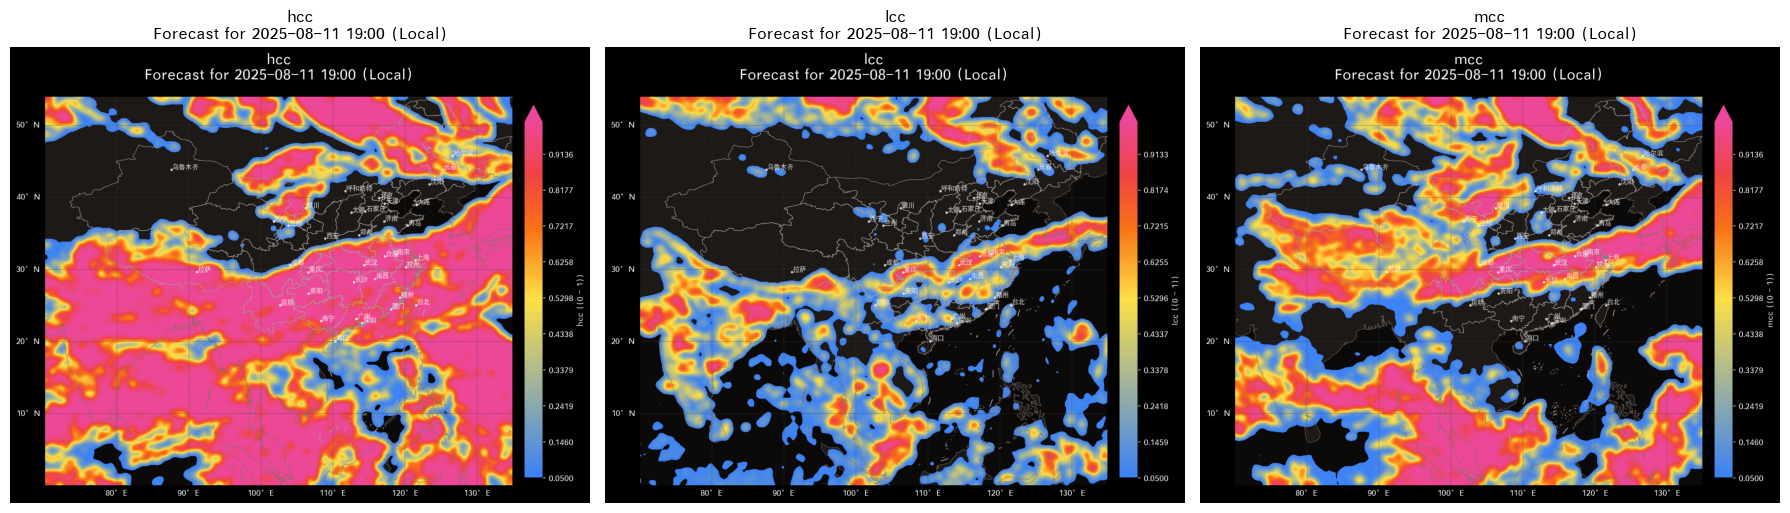

In [4]:
# --- 1. 寻找最新的 GFS 运行周期 ---
gfs_run_info = _find_latest_available_gfs_run()

if gfs_run_info:
    run_date, run_hour = gfs_run_info
    
    TARGET_EVENTS = expand_target_events(TARGET_EVENT_INTENTIONS)
    print(f"将要处理的详细事件列表: {TARGET_EVENTS}")
    
    # --- 2. 执行下载和处理流水线 ---
    logger.info("\n" + "="*80)
    logger.info(f"===== 开始为 {run_date} {run_hour}z 运行周期的 GFS 预报执行数据流水线 =====")
    
    processed_data = download_and_process_gfs_forecast(run_date, run_hour, TARGET_EVENTS)

    # --- 3. 可视化所有处理好的数据 ---
    # clear_output(wait=True)
    logger.info("✅ 所有数据处理完成，开始可视化...")
    
    if not processed_data:
        logger.warning("未能处理任何数据，无法进行可视化。")
    else:
        # 按事件分组进行可视化
        for event_name, nc_files in processed_data.items():
            if not nc_files: continue

            print("\n" + "="*80)
            print(f"--- 可视化事件: {event_name} ---")
            
            generated_images = []
            image_titles = []

            for file_path in sorted(nc_files):
                data_slice = xr.open_dataarray(file_path)
                
                utc_time_obj = datetime.fromisoformat(data_slice.attrs['original_utc_time'])
                local_dt = utc_time_obj.astimezone(ZoneInfo(config.LOCAL_TZ))
                
                map_title = (
                    f"{data_slice.attrs.get('long_name', data_slice.name)}\n"
                    f"Forecast for {local_dt.strftime('%Y-%m-%d %H:%M')} (Local)"
                )
                
                image_bytes = generate_map_from_grid(data_slice, map_title)
                if image_bytes:
                    generated_images.append(image_bytes)
                    image_titles.append(map_title)

            # 并排显示当前事件的所有变量地图
            if generated_images:
                num_images = len(generated_images)
                fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
                if num_images == 1: axes = [axes]
                for i, (img_bytes, title) in enumerate(zip(generated_images, image_titles)):
                    axes[i].imshow(plt.imread(io.BytesIO(img_bytes)))
                    axes[i].set_title(title)
                    axes[i].axis('off')
                plt.tight_layout()
                plt.show()
else:
    logger.error("❌ 未能找到可用的 GFS 运行周期，任务无法执行。")

In [5]:
import cfgrib

def diagnose_grib_steptypes(grib_path: Path):
    """
    诊断 GRIB2 文件中所有变量及其对应的 stepType。
    *** 已更新为使用 .items() 以兼容新版 cfgrib。***
    """
    if not grib_path.exists():
        print(f"❌ 诊断失败：文件不存在 {grib_path}")
        return

    print("\n" + "="*80)
    print(f"--- 正在诊断文件: {grib_path.name} ---")
    
    try:
        # 1. 直接将文件路径传递给 FileStream
        stream = cfgrib.FileStream(str(grib_path))
        
        var_steptypes = {}
        
        # ==========================================================
        # --- 核心修正：使用 stream.items() 进行迭代 ---
        # ==========================================================
        # .items() 返回一个 (offset, message) 的元组，我们只需要 message
        for _, msg in stream.items():
            var_name = msg.get('name', 'N/A')
            step_type = msg.get('stepType', 'N/A')
            
            if var_name not in var_steptypes:
                var_steptypes[var_name] = set()
            var_steptypes[var_name].add(step_type)
        # ==========================================================
            
        print("【变量名及其对应的 stepType】:")
        for name, types in sorted(var_steptypes.items()):
            print(f"  - {name:<30}: {types}")
            
    except Exception as e:
        print(f"❌ 诊断时发生错误: {e}")
    print("="*80 + "\n")

sample_grib_path = config.GFS_DATA_DIR / "20250808_t00z" / "today_sunset_1900_f011" / "forecast_data.grib2"
diagnose_grib_steptypes(sample_grib_path)


--- 正在诊断文件: forecast_data.grib2 ---
【变量名及其对应的 stepType】:
  - High cloud cover              : {'instant'}
  - Low cloud cover               : {'instant'}
  - Medium cloud cover            : {'instant'}
  - Time-mean high cloud cover    : {'avg'}
  - Time-mean low cloud cover     : {'avg'}
  - Time-mean medium cloud cover  : {'avg'}
  - Total Cloud Cover             : {'instant', 'avg'}

